In [10]:
# Zarr store decomposition: what is inside?

import os
import json
import glob
from pathlib import Path

import numpy as np
import xarray as xr

In [12]:
# ------------------------------------------------------------
# Root metadata details (Zarr v3)
# ------------------------------------------------------------

import json
from pathlib import Path

ZARR_PATH = Path("data/demo_eu_forecast.zarr")
root_meta = ZARR_PATH / "zarr.json"

with open(root_meta, "r") as f:
    meta = json.load(f)

print("node_type:", meta.get("node_type"))
print("zarr_format:", meta.get("zarr_format"))

print("\nRoot attributes keys:", list(meta.get("attributes", {}).keys()))

cm = meta.get("consolidated_metadata", None)
print("\nHas consolidated_metadata:", cm is not None)
if cm is not None:
    print("  consolidated_metadata keys:", list(cm.keys()))


node_type: group
zarr_format: 3

Root attributes keys: ['title', 'institution', 'history']

Has consolidated_metadata: True
  consolidated_metadata keys: ['kind', 'must_understand', 'metadata']


In [13]:
# ------------------------------------------------------------
# List arrays inside the store and check their metadata style
# ------------------------------------------------------------

items = sorted([p for p in ZARR_PATH.iterdir() if p.is_dir() and not p.name.startswith(".")])

print("Arrays / groups in store:")
for p in items:
    has_zarr_json = (p / "zarr.json").exists()
    has_zarray    = (p / ".zarray").exists()  # old v2-style, should be False in v3 stores
    print(f" - {p.name:10s} | zarr.json={has_zarr_json} | .zarray={has_zarray}")

Arrays / groups in store:
 - init_time  | zarr.json=True | .zarray=False
 - lat        | zarr.json=True | .zarray=False
 - lead_time  | zarr.json=True | .zarray=False
 - lon        | zarr.json=True | .zarray=False
 - mslp       | zarr.json=True | .zarray=False
 - t2m        | zarr.json=True | .zarray=False
 - tp         | zarr.json=True | .zarray=False
 - u10        | zarr.json=True | .zarray=False
 - v10        | zarr.json=True | .zarray=False
 - valid_time | zarr.json=True | .zarray=False


In [14]:
# ------------------------------------------------------------
# Inspect one array metadata (t2m)
# ------------------------------------------------------------

var = "t2m"
vp = ZARR_PATH / var
assert vp.exists(), f"Missing: {vp}"

with open(vp / "zarr.json", "r") as f:
    m = json.load(f)

print("Metadata keys:", list(m.keys()))

print("\nCore info:")
print(" node_type :", m.get("node_type"))
print(" zarr_format:", m.get("zarr_format"))
print(" shape     :", m.get("shape"))
print(" data_type :", m.get("data_type"))

# chunking in v3 is described via chunk_grid
cg = m.get("chunk_grid", {})
print("\nchunk_grid keys:", list(cg.keys()))
print("chunk_grid:", cg)

# codecs include compression
codecs = m.get("codecs", [])
print("\ncodecs:")
for c in codecs:
    print(" -", c.get("name"), "|", {k:v for k,v in c.items() if k not in ["name"]})

Metadata keys: ['shape', 'data_type', 'chunk_grid', 'chunk_key_encoding', 'fill_value', 'codecs', 'attributes', 'dimension_names', 'zarr_format', 'node_type', 'storage_transformers']

Core info:
 node_type : array
 zarr_format: 3
 shape     : [41, 121, 181]
 data_type : float32

chunk_grid keys: ['name', 'configuration']
chunk_grid: {'name': 'regular', 'configuration': {'chunk_shape': [1, 60, 60]}}

codecs:
 - bytes | {'configuration': {'endian': 'little'}}
 - zstd | {'configuration': {'level': 0, 'checksum': False}}


In [15]:
# ------------------------------------------------------------
# Chunk math from Zarr v3 metadata (t2m)
# ------------------------------------------------------------

import math
import numpy as np

def extract_chunks_from_v3_meta(m):
    """
    Try to extract chunk shape from Zarr v3 chunk_grid.
    Works for common v3 layouts.
    """
    cg = m.get("chunk_grid", {})
    conf = cg.get("configuration", {})
    # typical field: chunk_shape
    chunk_shape = conf.get("chunk_shape", None)
    return chunk_shape

chunk_shape = extract_chunks_from_v3_meta(m)
shape = m.get("shape", None)

print("shape:", shape)
print("chunk_shape:", chunk_shape)

if shape is not None and chunk_shape is not None:
    n_chunks = int(np.prod([math.ceil(s/c) for s, c in zip(shape, chunk_shape)]))
    print("estimated total chunks:", n_chunks)
else:
    print("Could not extract chunk shape from v3 metadata (implementation dependent).")

shape: [41, 121, 181]
chunk_shape: [1, 60, 60]
estimated total chunks: 492


In [16]:
# ------------------------------------------------------------
# On-disk chunk files (how the data is decomposed)
# ------------------------------------------------------------

import os
from pathlib import Path

def list_chunk_files(varname, max_show=20):
    var_dir = ZARR_PATH / varname
    assert var_dir.exists(), f"Missing {var_dir}"

    chunk_files = []
    for root, dirs, files in os.walk(var_dir):
        for fn in files:
            # skip metadata json files
            if fn.endswith(".json") or fn.startswith("."):
                continue
            chunk_files.append(Path(root) / fn)

    chunk_files = sorted(chunk_files)
    print(f"\n{varname}: chunk files = {len(chunk_files)}")
    for p in chunk_files[:max_show]:
        print("  -", p.relative_to(var_dir))

for v in ["t2m", "u10", "v10", "mslp", "tp"]:
    list_chunk_files(v, max_show=10)


t2m: chunk files = 492
  - c/0/0/0
  - c/0/0/1
  - c/0/0/2
  - c/0/0/3
  - c/0/1/0
  - c/0/1/1
  - c/0/1/2
  - c/0/1/3
  - c/0/2/0
  - c/0/2/1

u10: chunk files = 492
  - c/0/0/0
  - c/0/0/1
  - c/0/0/2
  - c/0/0/3
  - c/0/1/0
  - c/0/1/1
  - c/0/1/2
  - c/0/1/3
  - c/0/2/0
  - c/0/2/1

v10: chunk files = 492
  - c/0/0/0
  - c/0/0/1
  - c/0/0/2
  - c/0/0/3
  - c/0/1/0
  - c/0/1/1
  - c/0/1/2
  - c/0/1/3
  - c/0/2/0
  - c/0/2/1

mslp: chunk files = 492
  - c/0/0/0
  - c/0/0/1
  - c/0/0/2
  - c/0/0/3
  - c/0/1/0
  - c/0/1/1
  - c/0/1/2
  - c/0/1/3
  - c/0/2/0
  - c/0/2/1

tp: chunk files = 492
  - c/0/0/0
  - c/0/0/1
  - c/0/0/2
  - c/0/0/3
  - c/0/1/0
  - c/0/1/1
  - c/0/1/2
  - c/0/1/3
  - c/0/2/0
  - c/0/2/1


In [17]:
# ------------------------------------------------------------
# Disk usage per variable (compressed)
# ------------------------------------------------------------

def dir_size_bytes(p: Path):
    total = 0
    for root, dirs, files in os.walk(p):
        for fn in files:
            fp = Path(root) / fn
            total += fp.stat().st_size
    return total

store_mb = dir_size_bytes(ZARR_PATH) / 1e6
print(f"Total store size: {store_mb:.2f} MB\n")

for v in ["t2m", "u10", "v10", "mslp", "tp"]:
    mb = dir_size_bytes(ZARR_PATH / v) / 1e6
    print(f"{v:6s}: {mb:8.2f} MB")

Total store size: 15.16 MB

t2m   :     3.14 MB
u10   :     3.01 MB
v10   :     3.17 MB
mslp  :     2.62 MB
tp    :     3.19 MB


In [18]:
# ------------------------------------------------------------
# Why chunking matters: typical access patterns
# ------------------------------------------------------------

import time
import xarray as xr

ds = xr.open_zarr(ZARR_PATH)

# 1) One map at one lead time
t0 = time.time()
_ = ds["t2m"].isel(valid_time=10).load()
print("Read one map (t2m at one time):", f"{time.time()-t0:.3f} s")

# 2) One town timeseries
lat0, lon0 = 52.5200, 13.4050
t0 = time.time()
_ = ds["t2m"].sel(lat=lat0, lon=lon0, method="nearest").load()
print("Read one town time series:", f"{time.time()-t0:.3f} s")

# 3) Small patch cube (all time, local area)
t0 = time.time()
_ = ds["t2m"].sel(lat=slice(50, 55), lon=slice(5, 12)).load()
print("Read small area (all times):", f"{time.time()-t0:.3f} s")

Read one map (t2m at one time): 0.018 s
Read one town time series: 0.050 s
Read small area (all times): 0.037 s


In [26]:
# ------------------------------------------------------------
# Export patch-only images with GLOBAL color scale + diagnostics
# ------------------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

ds = xr.open_zarr(ZARR_PATH)

var = "t2m"
t_index = 10

chunk_lat = 60
chunk_lon = 60

OUTDIR = "zarr_patch_images"
os.makedirs(OUTDIR, exist_ok=True)

# load full field once (needed for global vmin/vmax and patch extraction)
da_full = ds[var].isel(valid_time=t_index).load()   # (lat, lon)
lat = da_full["lat"].values
lon = da_full["lon"].values
Y, X = da_full.shape

n_py = int(np.ceil(Y / chunk_lat))   # 3
n_px = int(np.ceil(X / chunk_lon))   # 4

# GLOBAL scale
vmin = float(np.nanmin(da_full.values))
vmax = float(np.nanmax(da_full.values))
print(f"{var} global vmin/vmax: {vmin:.3f} / {vmax:.3f}")
print(f"{var}: shape=({Y},{X}), chunks=({chunk_lat},{chunk_lon}) -> patches {n_py} x {n_px} = {n_py*n_px}")

def plot_patch_only(py, px):
    iy0 = py * chunk_lat
    ix0 = px * chunk_lon
    iy1 = min(iy0 + chunk_lat, Y)
    ix1 = min(ix0 + chunk_lon, X)

    # patch data only
    patch_vals = da_full.values[iy0:iy1, ix0:ix1]
    patch_lat  = lat[iy0:iy1]
    patch_lon  = lon[ix0:ix1]

    if patch_vals.size == 0:
        print(f"SKIP empty patch (py={py}, px={px})")
        return None

    pmin = float(np.nanmin(patch_vals))
    pmax = float(np.nanmax(patch_vals))
    print(f"patch (py={py}, px={px}) shape={patch_vals.shape} min/max={pmin:.3f}/{pmax:.3f}")

    # corners for rectangle
    lat0 = float(patch_lat[0]); lat1 = float(patch_lat[-1])
    lon0 = float(patch_lon[0]); lon1 = float(patch_lon[-1])

    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(11, 6))
    ax = plt.axes(projection=proj)

    # full Europe extent
    ax.set_extent([float(lon.min()), float(lon.max()), float(lat.min()), float(lat.max())], crs=proj)

    # map only
    ax.coastlines(resolution="110m", linewidth=1.0)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    # plot ONLY the patch values, but with global scaling
    im = ax.pcolormesh(
        patch_lon, patch_lat, patch_vals,
        shading="auto",
        transform=proj,
        vmin=vmin, vmax=vmax
    )

    # rectangle border
    ax.plot([lon0, lon1, lon1, lon0, lon0],
            [lat0, lat0, lat1, lat1, lat0],
            linewidth=3, transform=proj)

    ax.set_title(f"{var} patch-only | t_index={t_index} | (py={py}, px={px}) | iy={iy0}:{iy1}, ix={ix0}:{ix1}")

    cb = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.03)
    cb.set_label(f"{var} [{da_full.attrs.get('units','')}]")

    fn = os.path.join(OUTDIR, f"{var}_patchOnly_py{py}_px{px}.png")
    plt.tight_layout()
    plt.savefig(fn, dpi=160)
    plt.close(fig)
    return fn

files = []
for py in range(n_py):
    for px in range(n_px):
        fn = plot_patch_only(py, px)
        if fn is not None:
            files.append(fn)
            print("saved:", fn)

print(f"Done: {len(files)} images in {OUTDIR}/")


t2m global vmin/vmax: -3.609 / 22.015
t2m: shape=(121,181), chunks=(60,60) -> patches 3 x 4 = 12
patch (py=0, px=0) shape=(60, 60) min/max=9.164/21.169
saved: zarr_patch_images/t2m_patchOnly_py0_px0.png
patch (py=0, px=1) shape=(60, 60) min/max=9.862/20.757
saved: zarr_patch_images/t2m_patchOnly_py0_px1.png
patch (py=0, px=2) shape=(60, 60) min/max=6.938/22.015
saved: zarr_patch_images/t2m_patchOnly_py0_px2.png
patch (py=0, px=3) shape=(60, 1) min/max=6.860/19.774
saved: zarr_patch_images/t2m_patchOnly_py0_px3.png
patch (py=1, px=0) shape=(60, 60) min/max=-0.434/10.683
saved: zarr_patch_images/t2m_patchOnly_py1_px0.png
patch (py=1, px=1) shape=(60, 60) min/max=-1.162/12.727
saved: zarr_patch_images/t2m_patchOnly_py1_px1.png
patch (py=1, px=2) shape=(60, 60) min/max=-3.430/11.102
saved: zarr_patch_images/t2m_patchOnly_py1_px2.png
patch (py=1, px=3) shape=(60, 1) min/max=-3.457/6.694
saved: zarr_patch_images/t2m_patchOnly_py1_px3.png
patch (py=2, px=0) shape=(1, 60) min/max=-0.798/0.572


Found 12 images -> grid 3 x 4


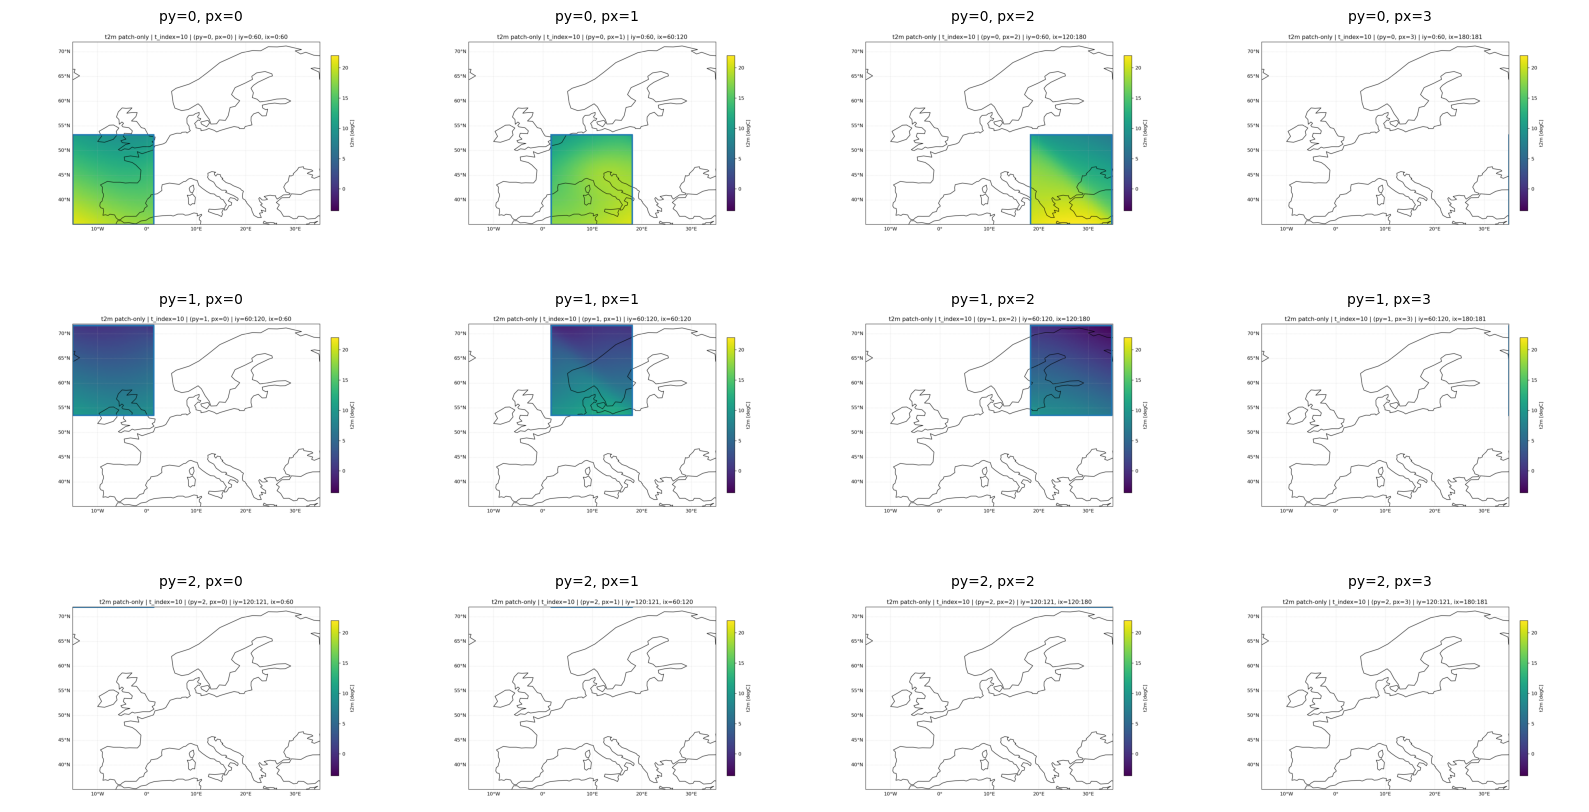

In [33]:
# ------------------------------------------------------------
# Display all patch images in a grid (3x4)
# ------------------------------------------------------------

import os
import re
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

OUTDIR = "zarr_patch_images"
var = "t2m"

# find images
files = glob.glob(os.path.join(OUTDIR, f"{var}_patchOnly_py*_px*.png"))
assert len(files) > 0, f"No images found in {OUTDIR}"

# parse (py, px) for sorting
pat = re.compile(r"_py(\d+)_px(\d+)\.png$")

def key_fn(fn):
    m = pat.search(fn)
    if m is None:
        return (999, 999)
    return (int(m.group(1)), int(m.group(2)))

files = sorted(files, key=key_fn)

# infer grid size from max indices
pys = [key_fn(f)[0] for f in files]
pxs = [key_fn(f)[1] for f in files]
n_py = max(pys) + 1
n_px = max(pxs) + 1

print(f"Found {len(files)} images -> grid {n_py} x {n_px}")

fig, axes = plt.subplots(n_py, n_px, figsize=(4*n_px, 3*n_py))

# axes can be 1D if n_py==1 or n_px==1; normalize
axes = np.atleast_2d(axes)

# fill grid
for ax in axes.ravel():
    ax.axis("off")

for fn in files:
    py, px = key_fn(fn)
    img = mpimg.imread(fn)

    ax = axes[py, px]
    ax.imshow(img)
    ax.set_title(f"py={py}, px={px}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig("zarr_patches_grid.png")
plt.show()

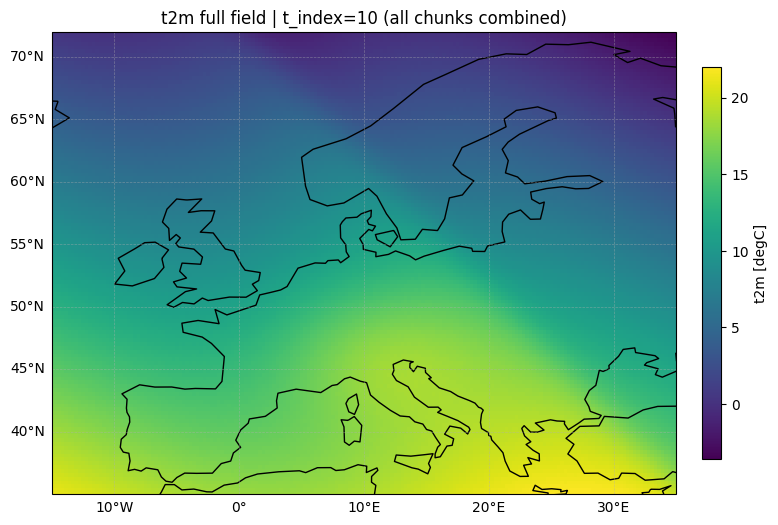

In [28]:
# ------------------------------------------------------------
# Show full field (all chunks together) for comparison
# ------------------------------------------------------------

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# reuse da_full, lat, lon, vmin, vmax from previous cell
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(11, 6))
ax = plt.axes(projection=proj)

# full Europe extent
ax.set_extent(
    [float(lon.min()), float(lon.max()),
     float(lat.min()), float(lat.max())],
    crs=proj
)

# map background
ax.coastlines(resolution="110m", linewidth=1.0)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# full field (this is effectively "all chunks assembled")
im = ax.pcolormesh(
    lon, lat, da_full.values,
    shading="auto",
    transform=proj,
    vmin=vmin, vmax=vmax
)

ax.set_title(f"{var} full field | t_index={t_index} (all chunks combined)")

cb = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.03)
cb.set_label(f"{var} [{da_full.attrs.get('units','')}]")

plt.show()

In [32]:
da_full

<xarray.DataArray 't2m' (lat: 121, lon: 181)> Size: 88kB
array([[21.168634  , 21.12557   , 21.043802  , ..., 20.248617  ,
        19.991856  , 19.774424  ],
       [20.985693  , 20.96424   , 20.881521  , ..., 19.86978   ,
        19.630762  , 19.3921    ],
       [20.879093  , 20.765495  , 20.734001  , ..., 19.524912  ,
        19.254768  , 18.949951  ],
       ...,
       [ 0.67998165,  0.694123  ,  0.6144418 , ..., -3.2140036 ,
        -3.2466843 , -3.2772088 ],
       [ 0.53497267,  0.5321819 ,  0.4456579 , ..., -3.375851  ,
        -3.4299212 , -3.4571733 ],
       [ 0.3737298 ,  0.3339759 ,  0.2836852 , ..., -3.4782028 ,
        -3.5341547 , -3.6092396 ]], shape=(121, 181), dtype=float32)
Coordinates:
  * lat         (lat) float64 968B 35.0 35.31 35.62 35.92 ... 71.38 71.69 72.0
  * lon         (lon) float64 1kB -15.0 -14.72 -14.44 ... 34.44 34.72 35.0
    init_time   datetime64[ns] 8B 2026-01-10
    lead_time   timedelta64[s] 8B 1 days 06:00:00
    valid_time  datetime64[ns] 8B 2026-01-11T06:00:00
Attributes:
    units:      degC
    long_name:  2m temperature